# <center> Catch Me If You Can

[Kaggle competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview)

Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. 

Здесь мы пытаемся идентифицировать пользователя в Интернете, отслеживая его/ее последовательность посещаемых веб-страниц. Алгоритм, который будет построен, будет принимать сеанс веб-страницы (последовательность веб-страниц, посещаемых, следовательно, одним и тем же человеком) и предсказывать, принадлежит ли он взломщику или кому-то еще

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

## Описание данных
В обучающей выборке train_sessions.csv:
* Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
* Признаки time_j – время посещения сайтов site_j
* Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Загружаем данные
train_df = pd.read_csv('data/train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id')

## Предобработка данных

In [3]:
# Приводим временные параметры (object по умолчанию) к datetime 
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [4]:
# Сортировка по времени начала сессии (site 1)
train_df = train_df.sort_values(by='time1')

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Если пользователь посетил 10 сайтов, сессия заканчивается, либо если он провел больше 30 минут в сессии

Заменим пропущенные значения у сайтов на ноль, остальные приведем к целочисленному формату

In [6]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

Загрузим словаь сайтов

In [7]:
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])
print(u'всего сайтов:', sites_dict_df.shape[0])
sites_dict_df.head()

всего сайтов: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


Выделим целевую переменную и объединим выборки, чтобы вместе привести их к разреженному формату.

In [8]:
# Таргет
y_train = train_df['target']

# Объединенная таблица
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Индекс по которому сплитится трейн и тест
idx_split = train_df.shape[0]

Используя данные по посещенным сайтам и словарем, преобразуем признаки (X_train/test_sparse), каждая новая фича будет соответствовать сайту, а значение по фиче будет соответствовать количеству посещений этого сайта за сессию

In [9]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [10]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0] + 10, 10)))[:, 1:]

In [11]:
X_train_sparse = full_sites_sparse[:idx_split,:]
X_test_sparse = full_sites_sparse[idx_split:,:]

In [12]:
X_train_sparse.shape, y_train.shape

((253561, 48371), (253561,))

##  Необходимые функции

**Функция, принимающая на вход обучающую выборку, реализует поиск лучших параметром логит-модели; возвращает самый высокий скор, параметры лучшей модели и саму модель**

In [13]:
def LR_auc_score(X, y, seed = 40):
    
    # Time split cv
    time_split = TimeSeriesSplit(n_splits = 5)
    
    # Логит - модель
    LR = LogisticRegression(random_state = seed, n_jobs = -1)
    
    # Параметры, подбирающиеся для логит-модели.
    grid_params = {'C':np.logspace(-3,1,10)}
    
    # Поиск лучшего параметра по сетке 
    grid_LR = GridSearchCV(LR,grid_params,scoring = 'roc_auc', cv = time_split, n_jobs = -1)
    grid_LR.fit(X,y)
    
    # Модель с самым высоким скором на обучающей выборке
    LR_best = grid_LR.best_estimator_
    
    # Параметры лучшей модели
    LR_best_params = grid_LR.best_params_
    
    # Скор лучшей модели по 5 фолдам
    LR_best_score = grid_LR.best_score_
    
    return [np.round(LR_best_score,3), LR_best, LR_best_params, grid_LR.cv_results_]

    

**Создадим функцию для записи сабмишенов в нужном формате**

In [14]:
def writing_sub(predicts, name, target = 'target', index_label = 'session_id'):
    predicts_df = pd.DataFrame(predicts, 
                               index = np.arange(1,len(predicts) + 1),
                               columns = [target])
    predicts_df.to_csv(name, index_label = 'session_id')

## Model1: Logit: bag_of_sites
Построим базовую модель

In [15]:
%%time
model_1 = LR_auc_score(X_train_sparse, y_train)

Wall time: 2min 2s


In [16]:
model_1_pred = model_1[1].predict_proba(X_test_sparse)[:,1]

In [17]:
model_1_score = model_1[0]
print(model_1_score)

0.834


In [18]:
writing_sub(model_1_pred, 'model_1_pred.csv')

**Kaggle sub_score = 0.90667** 

**Cross_val_score = 0.8342**

## Model2: Logit: bag_of_sites + time_features

Попробуем теперь включить в модель временные признаки (начало сессии)

In [19]:
times_df_train = pd.DataFrame(index = train_df.index)
times_df_test = pd.DataFrame(index = test_df.index)

### Start hour & day_time
**Посмотрим частоту посещения сайтов по часам, отдельно для взломщика и обычного пользователя**

In [20]:
hours_alias = train_df[train_df['target'] == 1]['time1'].apply(lambda x: x.hour)
hours_user = train_df[train_df['target'] == 0]['time1'].apply(lambda x: x.hour)

Text(0, 0.5, 'Frequency')

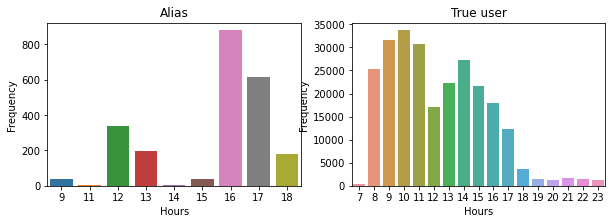

In [21]:
fig, axs = plt.subplots(1,2,figsize = (10,3))
sns.countplot(ax = axs[0], x = hours_alias)
axs[0].set_title('Alias')
axs[0].set_xlabel('Hours')
axs[0].set_ylabel('Frequency')
sns.countplot( ax = axs[1], x = hours_user)
axs[1].set_title('True user')
axs[1].set_xlabel('Hours')
axs[1].set_ylabel('Frequency')

Создадим признак, время начала сессии

In [22]:
times_df_train['start_hour'] = train_df['time1'].apply(lambda x: x.hour)
times_df_test['start_hour'] = test_df['time1'].apply(lambda x: x.hour)

Как видно исходя из графиков выше, можно заметить, что взломщик начинает сессию ближе к вечеру, попробуем использовать признак время дня (утро, день, вечер,ночь)

In [23]:
# Определим функция, преобразовывающая час-> время дня
def timeofday(x):
    hour = x.hour
    if 0 <= hour <= 6:
        return 'night'
    elif hour <= 11:
        return 'morning'
    elif hour <= 18:
        return 'day'
    elif  hour <= 23:
        return 'evening'

In [24]:
times_df_train['start_day_time'] = train_df['time1'].apply(timeofday)
times_df_test['start_day_time'] = test_df['time1'].apply(timeofday)

### start_weekday
**Попробуем также проверить отличаются ли от дня недели сессии взломщика и обычного пользователя**

In [25]:
weekday_alias = train_df[train_df['target'] == 1]['time1'].apply(lambda x: x.weekday())
weekday_user = train_df[train_df['target'] == 0]['time1'].apply(lambda x: x.weekday())

Text(0, 0.5, 'Frequency')

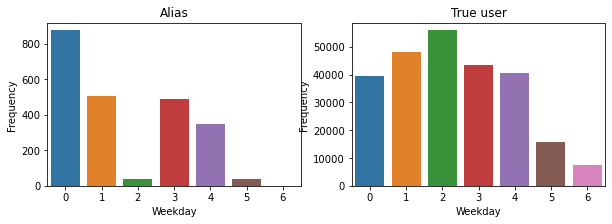

In [26]:
fig, axs = plt.subplots(1,2, figsize = (10,3))

sns.countplot(ax = axs[0], x = weekday_alias)
axs[0].set_title('Alias')
axs[0].set_xlabel('Weekday')
axs[0].set_ylabel('Frequency')

sns.countplot(ax = axs[1], x =weekday_user)
axs[1].set_title('True user')
axs[1].set_xlabel('Weekday')
axs[1].set_ylabel('Frequency')


Как видно из графиков выше, день недели также играет значение, соответственно используем как признак

In [27]:
times_df_train['start_weekday'] = train_df['time1'].apply(lambda x: x.weekday())
times_df_test['start_weekday'] = test_df['time1'].apply(lambda x: x.weekday())

### start_month
**Исходя из двух предыдущих пунктов, не будет сложно проверить отличаются ли сессии взломщика и обычного юзера от месяца**

In [28]:
month_alias = train_df[train_df['target'] == 1]['time1'].apply(lambda x: x.month)
month_user = train_df[train_df['target'] == 0]['time1'].apply(lambda x: x.month)

Text(0, 0.5, 'Frequency')

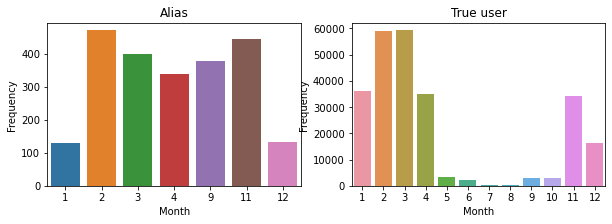

In [29]:
fig, axs = plt.subplots(1,2, figsize = (10,3))

sns.countplot(ax = axs[0], x = month_alias)
axs[0].set_title('Alias')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Frequency')

sns.countplot(ax = axs[1], x =month_user)
axs[1].set_title('True user')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Frequency')

Что и следовало ожидать, месяц также будет хорошим признаком

In [30]:
times_df_train['start_month'] = train_df['time1'].apply(lambda x: x.month)
times_df_test['start_month'] = test_df['time1'].apply(lambda x: x.month)

### start_year
**Будет неожиданно, если год не играет роли**

In [31]:
year_alias = train_df[train_df['target'] == 1]['time1'].apply(lambda x: x.year)
year_user = train_df[train_df['target'] == 0]['time1'].apply(lambda x: x.year)

Text(0, 0.5, 'Frequency')

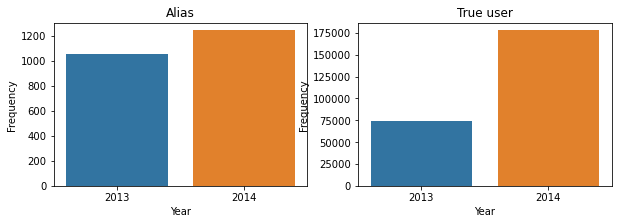

In [32]:
fig, axs = plt.subplots(1,2, figsize = (10,3))

sns.countplot(ax = axs[0], x = year_alias)
axs[0].set_title('Alias')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Frequency')

sns.countplot(ax = axs[1], x =year_user)
axs[1].set_title('True user')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Frequency')

Год также отличает взломщика от юзера.

In [33]:
times_df_train['start_year'] = train_df['time1'].apply(lambda x: x.year)
times_df_test['start_year'] = test_df['time1'].apply(lambda x: x.year)

### start_month_weekday

In [34]:
weekday_month_alias = train_df[train_df['target'] == 1]['time1'].apply(lambda x: x.month*10 + x.weekday())
weekday_month_user = train_df[train_df['target'] == 0]['time1'].apply(lambda x: x.month*10 + x.weekday())

Text(0, 0.5, 'Frequency')

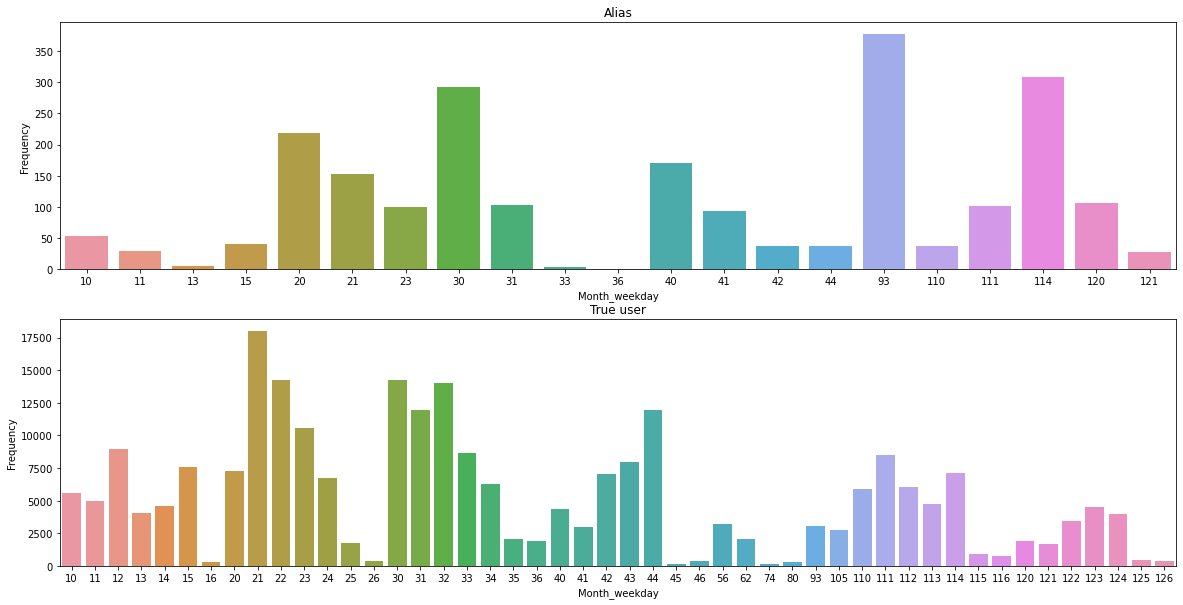

In [35]:
fig, axs = plt.subplots(2,1, figsize = (20,10))

sns.countplot(ax = axs[0], x = weekday_month_alias)
axs[0].set_title('Alias')
axs[0].set_xlabel('Month_weekday')
axs[0].set_ylabel('Frequency')

sns.countplot(ax = axs[1], x = weekday_month_user)
axs[1].set_title('True user')
axs[1].set_xlabel('Month_weekday')
axs[1].set_ylabel('Frequency')

In [36]:
times_df_train['start_month_weekday'] = train_df['time1'].apply(lambda x: x.month*10 + x.weekday())
times_df_test['start_month_weekday'] = test_df['time1'].apply(lambda x: x.month*10 + x.weekday())

**Попробуем обучить модель на сгенерированных признаках. Взглянем на результаты**

In [37]:
times_df_train.head()

,start_hour,start_day_time,start_weekday,start_month,start_year,start_month_weekday
session_id,,,,,,
21669,8,morning,5,1,2013,15
54843,8,morning,5,1,2013,15
77292,8,morning,5,1,2013,15
114021,8,morning,5,1,2013,15
146670,8,morning,5,1,2013,15


In [38]:
# Используем one-hot-encoding для кодировки временных признаков
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(times_df_train)
times_train_oh = encoder.transform(times_df_train)
times_test_oh = encoder.transform(times_df_test)

In [39]:
# обучающая выборка
sites_times_train = hstack([times_train_oh, X_train_sparse])
# тестовая выборка
sites_times_test = hstack([times_test_oh, X_test_sparse])

In [40]:
# Обучим логит-модель на трейне, посмотрим на качество модели и сделаем предсказания на тестовой выборке
model_2 = LR_auc_score(sites_times_train, y_train)

In [41]:
print(f'cross_val_score = {model_2[0]}')

cross_val_score = 0.942


In [42]:
model_2_pred = model_2[1].predict_proba(sites_times_test)[:,1]

In [43]:
writing_sub(model_2_pred, 'model_2_pred.csv')

**Kaggle sub_score = 0.945** 

**Cross_val_score = 0.942**

Результат улучшился. Есть еще пара идей насчет новых признаков. Далее реализуем их

## Model3: Logit: bag_of_sites + start_time_features + session_time + n_sites + start_site

### n_sites
Посмотрим, отличается ли количество посещенных сайтов у взломщика и у рядового юзера

In [44]:
train_df['n_sites'] = train_df[times].apply(lambda x: 10 - x.isnull().values.sum(),axis = 1)
test_df['n_sites'] = test_df[times].apply(lambda x: 10 - x.isnull().values.sum(),axis = 1)

In [45]:
n_sites_alias = train_df[train_df['target'] == 1].query('n_sites <10')['n_sites']
n_sites_user = train_df[train_df['target'] == 0].query('n_sites <10')['n_sites']

Text(0, 0.5, 'Frequency')

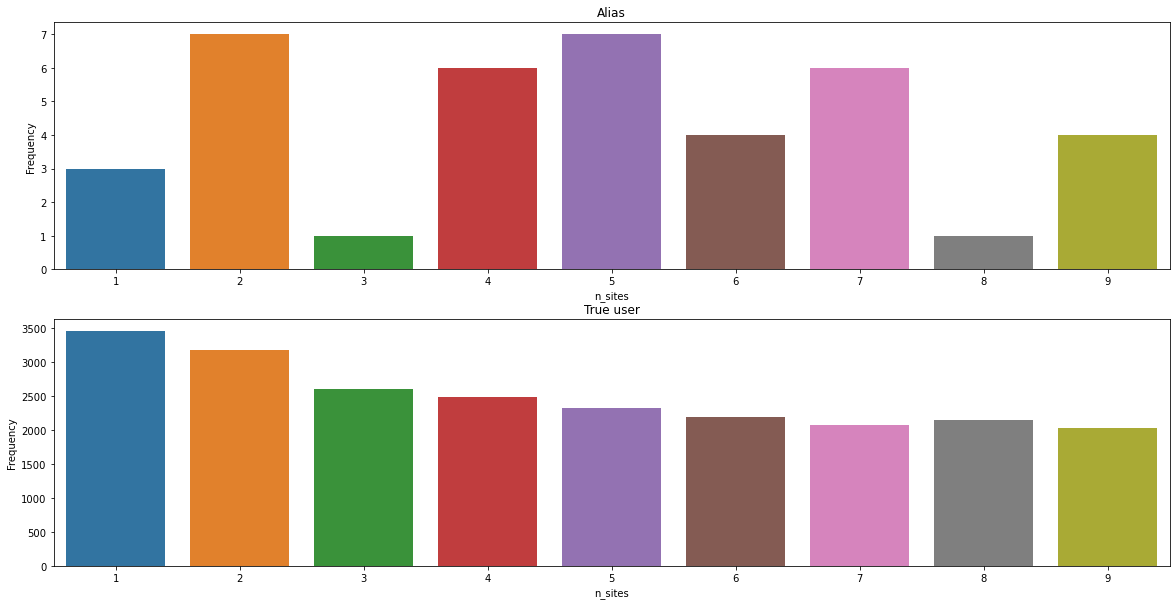

In [46]:
fig, axs = plt.subplots(2,1, figsize = (20,10))

sns.countplot(ax = axs[0], x = n_sites_alias)
axs[0].set_title('Alias')
axs[0].set_xlabel('n_sites')
axs[0].set_ylabel('Frequency')

sns.countplot(ax = axs[1], x = n_sites_user)
axs[1].set_title('True user')
axs[1].set_xlabel('n_sites')
axs[1].set_ylabel('Frequency')

Как мы видим, количество сайтов за сессию, немаловажный признак

In [47]:
times_df_train['n_sites'] = train_df['n_sites']
times_df_test['n_sites'] = test_df['n_sites']

### start_site

In [48]:
train_df.groupby('target')\
.site1\
.value_counts(normalize = True)\
.to_frame()\
.rename(columns = {'site1':'percent'})\
.reset_index()\
.pivot(index = 'site1', columns = 'target',values = 'percent')\
.sort_values(1, ascending = False)\
.head(5)

target,0,1
site1,,
80,0.011940,0.061820
77,0.006483,0.061384
76,0.007677,0.056596
29,0.021503,0.042664
21,0.054898,0.034828


Как мы видим, взломщики обычно начинают сессию с сайта под номером 80, 77 и 76. Давайте создадим признак, началась ли сессия с сайта под одним из этих номеров

In [49]:
times_df_train['start_site'] = train_df['site1'].apply(lambda x: int( x in [80,77,76]))
times_df_test['start_site'] = test_df['site1'].apply(lambda x: int( x in [80,77,76]))

### Добавим признак время сессии

In [50]:
ses_sec_train = train_df[times].apply(lambda x: (x.max() - x.min()).total_seconds(), axis = 1).astype('int')
ses_sec_test = test_df[times].apply(lambda x: (x.max() - x.min()).total_seconds(), axis = 1).astype('int')

In [51]:
times_df_train['time_sess'] = ses_sec_train 
times_df_test['time_sess'] = ses_sec_test

## Итоговая модель

In [52]:
# Используем standard-scaler для масштабирования признака - время сессии
scaler = StandardScaler()
scaler.fit(times_df_train['time_sess'].values.reshape(-1,1))
time_ses_train = scaler.transform(times_df_train['time_sess'].values.reshape(-1,1))
time_ses_test = scaler.transform(times_df_test['time_sess'].values.reshape(-1,1))

In [53]:
# Используем one-hot-encoding для кодировки временных признаков
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(times_df_train.drop(['time_sess','start_site'], axis = 1))
times_train_oh = encoder.transform(times_df_train.drop(['time_sess','start_site'], axis = 1))
times_test_oh = encoder.transform(times_df_test.drop(['time_sess','start_site'], axis = 1))

In [54]:
# обучающая выборка
sites_times_train = hstack([times_train_oh, X_train_sparse, time_ses_train, times_df_train['start_site'].values.reshape(-1,1)])
# тестовая выборка
sites_times_test = hstack([times_test_oh, X_test_sparse, time_ses_test, times_df_test['start_site'].values.reshape(-1,1)])

In [55]:
model_3 = LR_auc_score(sites_times_train, y_train)

In [56]:
print(f'cross_val_score = {model_3[0]}')

cross_val_score = 0.943


In [57]:
C_param = model_3[2]['C']

In [58]:
print(f'C param = {C_param}')

C param = 0.46415888336127775


Следует дофитить модель, то есть подобрать более подходящий параметр регуляризации. 

In [59]:
# Time split cv
time_split = TimeSeriesSplit(n_splits = 5)

# Логит - модель
LR = LogisticRegression(random_state = 40, n_jobs = -1)

# Параметры, подбирающиеся для логит-модели.
grid_params = {'C':np.linspace(0.1, 1.3,10)}

# Поиск лучшего параметра по сетке 
grid_LR = GridSearchCV(LR,grid_params,scoring = 'roc_auc', cv = time_split, n_jobs = -1)
grid_LR.fit(sites_times_train,y_train)

# Модель с самым высоким скором на обучающей выборке
LR_best = grid_LR.best_estimator_

# Параметры лучшей модели
LR_best_params = grid_LR.best_params_

# Скор лучшей модели по 5 фолдам
LR_best_score = grid_LR.best_score_

In [60]:
# Предскажем таргет на тестовой выборке
model_4_pred = LR_best.predict_proba(sites_times_test)[:,1]

In [61]:
writing_sub(model_4_pred, 'model_4_pred.csv')

**Kaggle sub_score = 0.947** 

**Cross_val_score = 0.943**